In [62]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta

five_yrs_ago = date.today() - relativedelta(years=5)

In [63]:
df= yf.download('TATAMOTORS.NS', start=five_yrs_ago.strftime("%Y-%m-%d"), end= date.today().strftime("%Y-%m-%d"))
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-10,427.799988,433.000000,424.000000,432.299988,432.299988,5378402
2017-05-11,434.000000,434.500000,425.399994,427.450012,427.450012,4049649
2017-05-12,429.649994,433.799988,427.450012,430.850006,430.850006,3850940
2017-05-15,434.000000,434.000000,430.100006,431.899994,431.899994,1885702
2017-05-16,432.250000,439.500000,432.250000,437.250000,437.250000,3452072


In [64]:
df= df.loc[:, 'High']
df

Date
2017-05-10    433.000000
2017-05-11    434.500000
2017-05-12    433.799988
2017-05-15    434.000000
2017-05-16    439.500000
                 ...    
2022-05-02    442.950012
2022-05-04    440.600006
2022-05-05    434.000000
2022-05-06    420.200012
2022-05-09    407.399994
Name: High, Length: 1235, dtype: float64

In [65]:
df= df.values.reshape(-1,1)
df_train, df_test= df[:int(0.8*len(df)),0], df[int(0.8*len(df)):,0]
len(df_test)

247

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
scaler= MinMaxScaler(feature_range=(-1,1))
scaled_df= scaler.fit_transform(df)

In [68]:
x_train= []
y_train= []
time_step= 100
for i in range(time_step, len(df_train)):
    x_train.append(scaled_df[i-time_step:i,0])
    y_train.append(scaled_df[i,0])

In [69]:
x_train, y_train= np.array(x_train), np.array(y_train)

In [70]:
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))


In [71]:
import torch
import torch.nn as nn

In [72]:
device= torch.device('cuda')

In [73]:
x_train= torch.from_numpy(x_train).type(torch.Tensor)
y_train= torch.from_numpy(y_train).type(torch.Tensor)

In [74]:
y_train.shape
y_train= np.reshape(y_train, (y_train.shape[0], 1))

In [75]:
input_dim=1
hidden_dim_lstm= 16
num_layers_lstm= 2         #number of stacks of lstm
output_dim= 1
epochs_lstm= 1000

In [76]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim= hidden_dim
        self.num_layers= num_layers
        self.lstm= nn.LSTM(input_dim, hidden_dim, num_layers, batch_first= True)
        self.fc= nn.Linear(hidden_dim, output_dim)          #fully connected layer after lstm
    def forward(self, x):
        h0= torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()               #.requires_grad is for computing gradients
        c0= torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn,cn)= self.lstm(x, (h0.detach(), c0.detach()))
        out= self.fc(out[:,-1,:])           #This represents the final state of the lstm as the output.
        return out

In [77]:
model_lstm= LSTM(input_dim= input_dim, hidden_dim= hidden_dim_lstm, output_dim= output_dim, num_layers= num_layers_lstm)
criterion= torch.nn.MSELoss(reduction= 'mean')
optimizer= torch.optim.Adam(model_lstm.parameters(), lr= 0.01)

In [78]:
model_lstm.cuda()

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [79]:
for e in range(epochs_lstm):
    y_train_pred= model_lstm(x_train.cuda())
    loss= criterion(y_train_pred, y_train.cuda())
    optimizer.zero_grad()
    loss.backward()         #Backpropogation
    optimizer.step()        #Gradient descent step

In [80]:
model_lstm.train()

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [81]:
test_input= scaled_df[len(df)-len(df_test)-time_step:,0]

In [82]:
x_test=[]
for i in range(time_step, len(test_input)):
    x_test.append(test_input[i-time_step:i])
x_test= np.array(x_test)
x_test= torch.from_numpy(np.reshape(x_test,( x_test.shape[0], x_test.shape[1],1))).type(torch.Tensor)

In [83]:
y_test_pred_lstm= model_lstm(x_test.cuda())

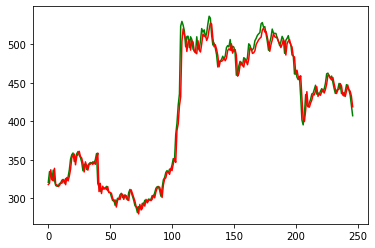

In [84]:
import matplotlib.pyplot as plt
pred_lstm= scaler.inverse_transform(y_test_pred_lstm.cpu().detach().numpy())
plt.plot(df_test, color= 'green', label='Real')
plt.plot(pred_lstm, color= 'red', label='Predicted')

In [85]:
print(f'Tomorrow\'s price will be {pred_lstm[-1,0]}')

Tomorrow's price will be 419.0067443847656


In [86]:
from sklearn.metrics import r2_score
print(r2_score(pred_lstm[:-1],df_test[1:]))

0.961960856275634
